<a href="https://colab.research.google.com/github/AZVR3/tuberculosis-tensorflow/blob/main/TPU_tuberculosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"azure33","key":"b0e76c5f6657dc66a5a3b13d3cf726d5"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download tawsifurrahman/tuberculosis-tb-chest-xray-dataset
!unzip tuberculosis-tb-chest-xray-dataset.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
tuberculosis-tb-chest-xray-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  tuberculosis-tb-chest-xray-dataset.zip
replace TB_Chest_Radiography_Database/Normal.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: TB_Chest_Radiography_Database/Normal.metadata.xlsx  
replace TB_Chest_Radiography_Database/Normal/Normal-1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace TB_Chest_Radiography_Database/Normal/Normal-1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: TB_Chest_Radiography_Database/Normal/Nor

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)
print(strategy)

In [ ]:
# Define image dimensions (resize for consistency)
IMG_HEIGHT, IMG_WIDTH = 128, 128

# Paths to datasets
no_tb_data = "/content/TB_Chest_Radiography_Database/Normal"
tb_data = "/content/TB_Chest_Radiography_Database/Tuberculosis"

In [ ]:
# Function to load and preprocess images
def load_images_and_labels(path, label):
    images = []
    labels = []
    for file_name in os.listdir(path):
        file_path = os.path.join(path, file_name)
        if os.path.isfile(file_path):
            # Load image and preprocess (resize and normalize)
            img = cv.imread(file_path, cv.IMREAD_GRAYSCALE)  # Load in grayscale
            img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = img / 255.0  # Normalize pixel values to [0, 1]
            images.append(img)
            labels.append(label)
    return images, labels

# Load Normal and Tuberculosis images
normal_images, normal_labels = load_images_and_labels(no_tb_data, 0)
tb_images, tb_labels = load_images_and_labels(tb_data, 1)

# Combine data and labels
images = np.array(normal_images + tb_images)
labels = np.array(normal_labels + tb_labels)

# Split into training and testing datasets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Ensure data shape matches input requirements for TensorFlow
train_images = np.expand_dims(train_images, axis=-1)  # Add channel dimension
test_images = np.expand_dims(test_images, axis=-1)

print(f"Training data shape: {train_images.shape}")
print(f"Testing data shape: {test_images.shape}")

Training data shape: (3360, 128, 128, 1)
Testing data shape: (840, 128, 128, 1)


In [ ]:
with strategy.scope():
  # Build a basic CNN model
  model = models.Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(128, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(1, activation='sigmoid')  # Binary classification
  ])

  # Compile the model
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7563 - loss: 0.4321 - val_accuracy: 0.9238 - val_loss: 0.1350
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9503 - loss: 0.1844 - val_accuracy: 0.9333 - val_loss: 0.1725
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9644 - loss: 0.0888 - val_accuracy: 0.9524 - val_loss: 0.1525
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9648 - loss: 0.0665 - val_accuracy: 0.9429 - val_loss: 0.1817
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9889 - loss: 0.0364 - val_accuracy: 0.9524 - val_loss: 0.1294
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9806 - loss: 0.0380 - val_accuracy: 0.9524 - val_loss: 0.1196
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9966 - loss: 0.0237 - val_accuracy: 0.9524 - val_loss: 0.2867
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9821 - loss: 0.0318 - val_acc

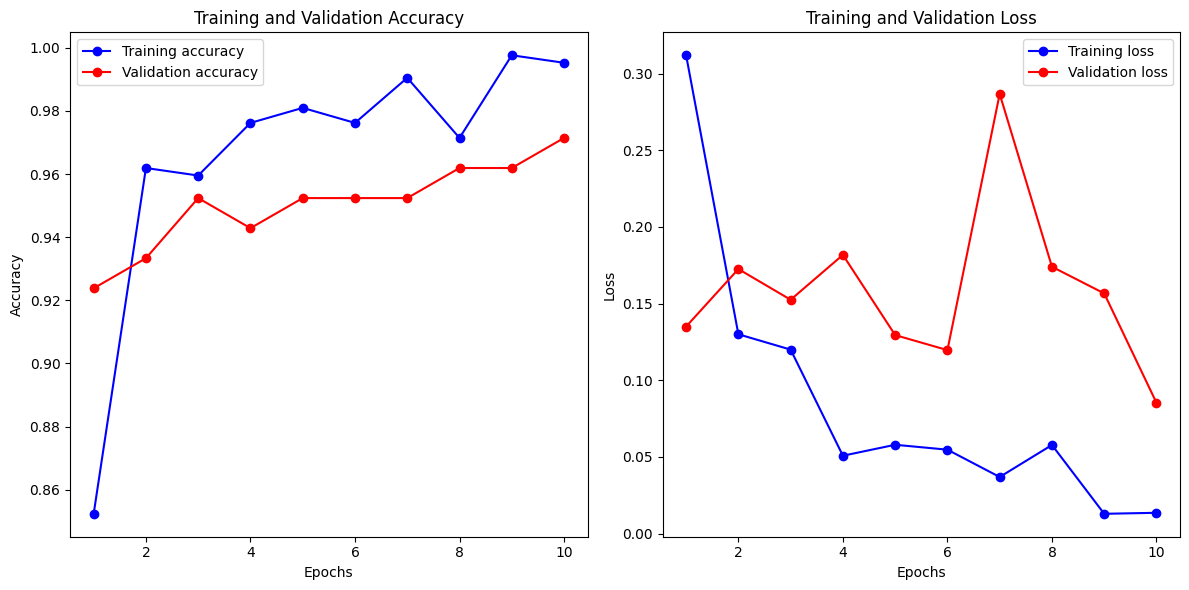

In [ ]:
# Visualize accuracy and loss over epochs
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)